In [34]:
import numpy as np
from collections import defaultdict
np.set_printoptions(suppress=True, precision=3)
rng = np.random.default_rng(42)

# Gridworld 4x4: stati 0..15, azioni: 0=left, 1=down, 2=right, 3=up
N = 4
S = N * N
A = 4
START, GOAL = 0, S-1

def step_det(s, a):
    r, c = divmod(s, N)
    if a == 0:  # left
        c = max(0, c-1)
    elif a == 1:  # down
        r = min(N-1, r+1)
    elif a == 2:  # right
        c = min(N-1, c+1)
    elif a == 3:  # up
        r = max(0, r-1)
    s_next = r*N + c
    done = (s_next == GOAL)
    reward = 1.0 if done else -0.01
    return s_next, reward, done


In [35]:
def greedy_towards_goal(s):
    r, c = divmod(s, N)
    gr, gc = divmod(GOAL, N)
    moves = []
    if gc > c: moves.append(2)  # right
    if gc < c: moves.append(0)  # left
    if gr > r: moves.append(1)  # down
    if gr < r: moves.append(3)  # up
    if not moves:  # già al goal
        moves = [0,1,2,3]
    return rng.choice(moves)

def collect_dataset(num_episodes=500, max_steps=30, p_greedy=0.8):
    data = []  # (s, a, r, s_next, done)
    successes = 0
    for _ in range(num_episodes):
        s = START
        for t in range(max_steps):
            if rng.random() < p_greedy:
                a = greedy_towards_goal(s)
            else:
                a = rng.integers(0, A)
            s_next, r, done = step_det(s, a)
            data.append((s, a, r, s_next, done))
            s = s_next
            if done:
                successes += 1
                break
    return np.array(data, dtype=object), successes

dataset, succ = collect_dataset(num_episodes=800, max_steps=40, p_greedy=0.8)
print("Transizioni nel dataset:", dataset.shape[0], " — Episodi riusciti:", succ)
# esempio riga
dataset[0]


Transizioni nel dataset: 5874  — Episodi riusciti: 800


array([0, np.int64(1), -0.01, 4, False], dtype=object)

In [38]:
# Q-table iniziale
Q = np.zeros((S, A), dtype=np.float32)

gamma = 0.99
alpha0 = 0.5
epochs = 50  # ripassi completi sul dataset
shuffle = True

for e in range(1, epochs+1):
    if shuffle:
        rng.shuffle(dataset)
    alpha = max(0.05, alpha0 * (0.98 ** e))  # lr decrescente
    for s, a, r, s_next, done in dataset:
        target = r if done else r + gamma * np.max(Q[s_next])
        Q[s, a] += alpha * (target - Q[s, a])

print("Q max/min:", Q.max(), Q.min())
# Policy greedily ottimale appresa
pi = np.argmax(Q, axis=1).reshape(N, N)
pi


Q max/min: 0.99999994 0.0


array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 0]])

In [39]:
def rollout(policy, max_steps=40):
    s = START
    total_r = 0.0
    traj = [s]
    for t in range(max_steps):
        a = policy[s]
        s, r, done = step_det(s, a)
        total_r += r
        traj.append(s)
        if done:
            break
    return total_r, traj, done

ret, traj, solved = rollout(np.argmax(Q, axis=1), max_steps=40)
print("Solved:", solved, "Return:", ret, "Traiettoria (stati):", traj)


Solved: True Return: 0.95 Traiettoria (stati): [0, 4, 8, 12, 13, 14, 15]


In [41]:
def draw_path(traj):
    grid = np.full((N, N), '.', dtype=object)
    r0, c0 = divmod(START, N); grid[r0, c0] = 'S'
    rg, cg = divmod(GOAL, N);  grid[rg, cg] = 'G'
    for s in traj[1:-1]:
        r, c = divmod(s, N)
        grid[r, c] = '·'  # puntino sul percorso
    print("\nPercorso:")
    for r in range(N):
        print(" ".join(grid[r]))
    print()

draw_path(traj)



Percorso:
S . . .
· . . .
· . . .
· · · G



In [42]:
import matplotlib.pyplot as plt
import numpy as np

arrows = {0:'←', 1:'↓', 2:'→', 3:'↑'}
policy = np.argmax(Q, axis=1).reshape(N, N)

def show_policy(pi):
    print("Policy appresa (direzioni):")
    for r in range(N):
        row = ""
        for c in range(N):
            s = r*N + c
            if s == START: row += 'S '
            elif s == GOAL: row += 'G '
            else: row += arrows[pi[r, c]] + ' '
        print(row)
    print()

show_policy(policy)


Policy appresa (direzioni):
S ↓ ↓ ↓ 
↓ ↓ ↓ ↓ 
↓ ↓ ↓ ↓ 
→ → → G 



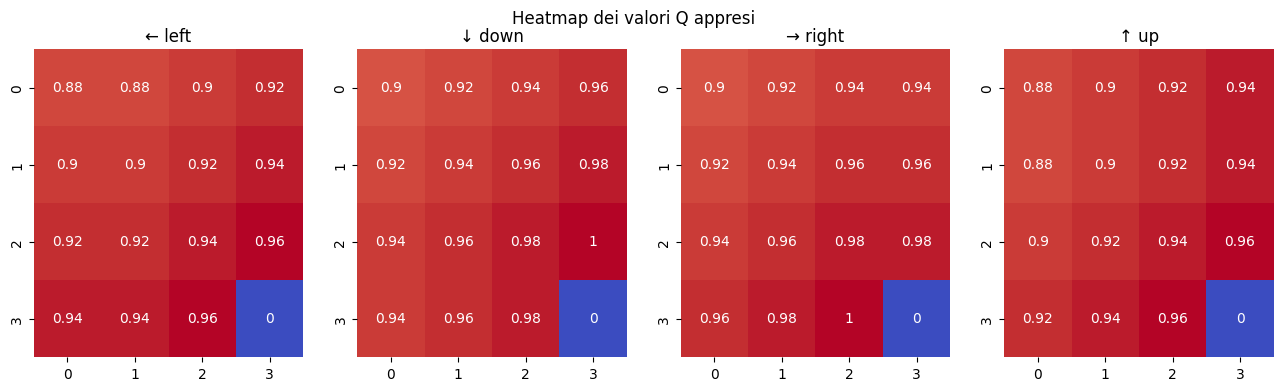

In [44]:
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(16,4))
titles = ['← left', '↓ down', '→ right', '↑ up']
for a in range(4):
    q_grid = Q[:, a].reshape(N, N)
    sns.heatmap(q_grid, ax=axes[a], annot=True, cmap='coolwarm', cbar=False)
    axes[a].set_title(titles[a])
plt.suptitle("Heatmap dei valori Q appresi")
plt.show()
